In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pywt
import os
import numpy as np

from preferences import *

In [15]:
files_wav = list()

for dir in os.scandir(os.path.join(RESOURCES_PATH, 'samples')):
    if dir.name == '.DS_Store': continue

    for file in os.scandir(dir.path):
        
        # Skip all non-audio files
        name_split = os.path.splitext(file.name)
        file_ext = name_split[1][1:]
        if file_ext.lower() != 'wav': continue
        
        # Append to list of audio files
        files_wav.append(file)

len(files_wav)

49

In [18]:
RUN = False
if RUN:

    fig, axs = plt.subplots(7, 7, figsize=(100,60))

    for id, file in enumerate(files_wav):
        sampling_freq, data = wavfile.read(file.path)

        # Pre-fill cell
        i = id // 7
        j = id % 7
        axs[i, j].set_title(file.name)
        axs[i, j].set_xlabel('Time')
        axs[i, j].set_ylabel('Frequency')

        # Skip empty files
        if data.shape[0] == 0: continue
        
        # Add spectrogram
        signal = data[:, 0]
        axs[i, j].specgram(signal, Fs=sampling_freq)


    fig.savefig('full_figure.png', bbox_inches='tight')


In [8]:
for file in files_wav:
    sampling_freq, data = wavfile.read(file.path)

    # Skip empty files
    if data.shape[0] == 0: continue
    signal_0 = data[:, 0]

    
    # print(f'{file.name} – {data.shape} ({sampling_freq})')

    # plt.figure(figsize=(15, 10))

    # plt.specgram(signal_0, Fs=sampling_freq)

    # plt.title(file.name)
    # plt.xlabel('Time')
    # plt.ylabel('Frequency')

    # plt.show()



## 1. Test on one signal

### 1.1. Import data

In [121]:
# Import data
filepath = os.path.join(RESOURCES_PATH, 'samples/2020_01_28_3A/2020_01_28_1.wav')
sampling_freq, data = wavfile.read(filepath)
sig = data[:, 0]

In [122]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sig_reshaped = sig.reshape(-1, 1)
scaler.fit(sig_reshaped)  # unlimited lines, one column
sig_std = scaler.transform(sig_reshaped).flatten()

<br>

### 1.2. Plot signal's temporal evolution

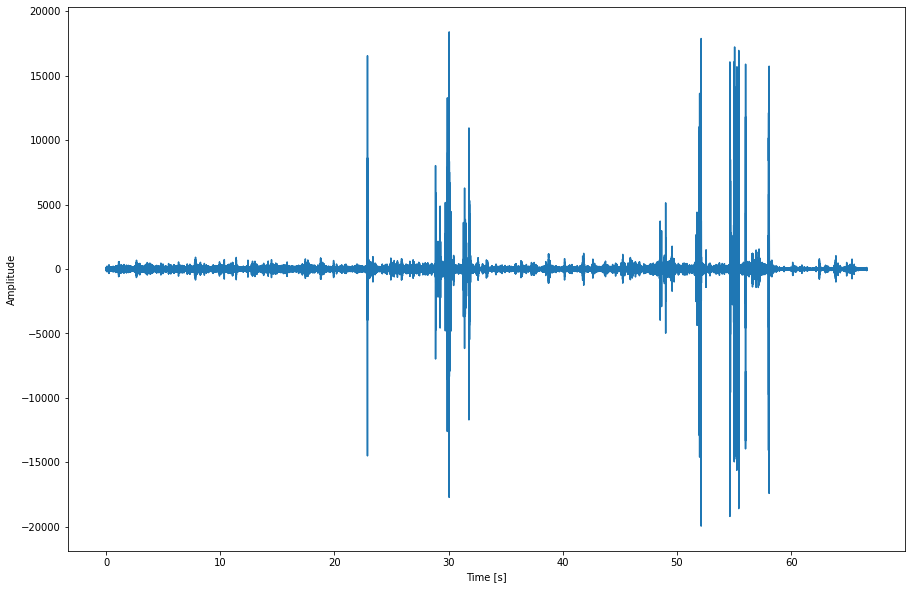

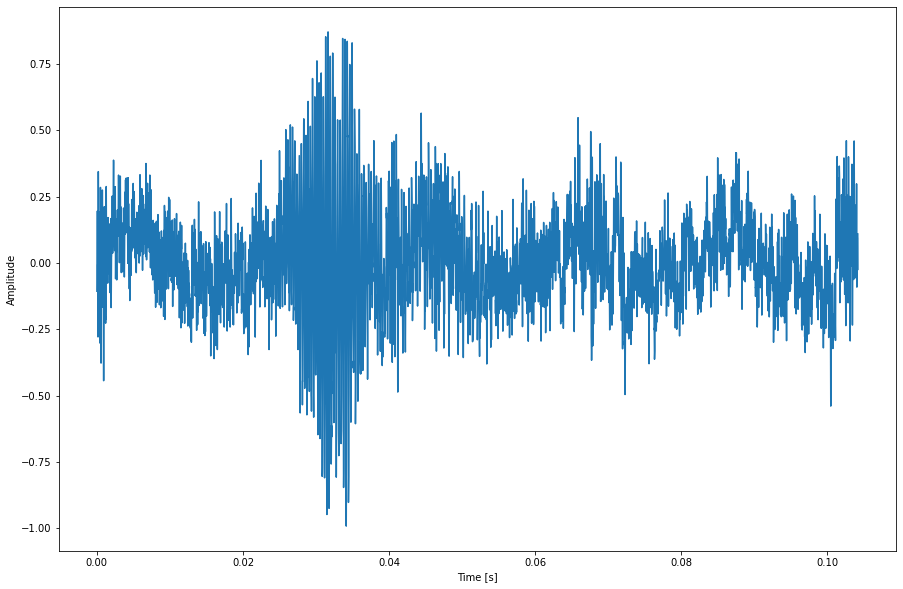

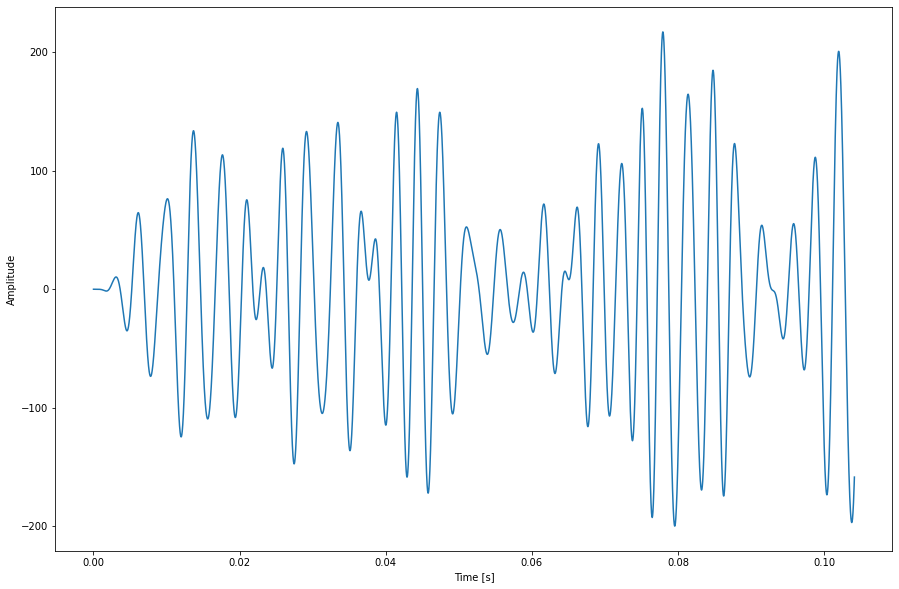

In [186]:
# Plot signal over time

def plot_sig (sig: np.ndarray, sampling_freq: int, title: str = None):
    plt.figure(figsize=(15, 10))
    plt.plot(np.arange(sig.shape[0]) / sampling_freq, sig)

    if title: plt.title(title)

    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.show()


plot_sig(sig, sampling_freq)


sample = sig_std[:10000]
plot_sig(sample, sampling_freq)
plot_sig(sig[:10000], sampling_freq)
# plot_sig(signal_std[:10000], sampling_freq)

<br>

### 1.3. Fourier transforms

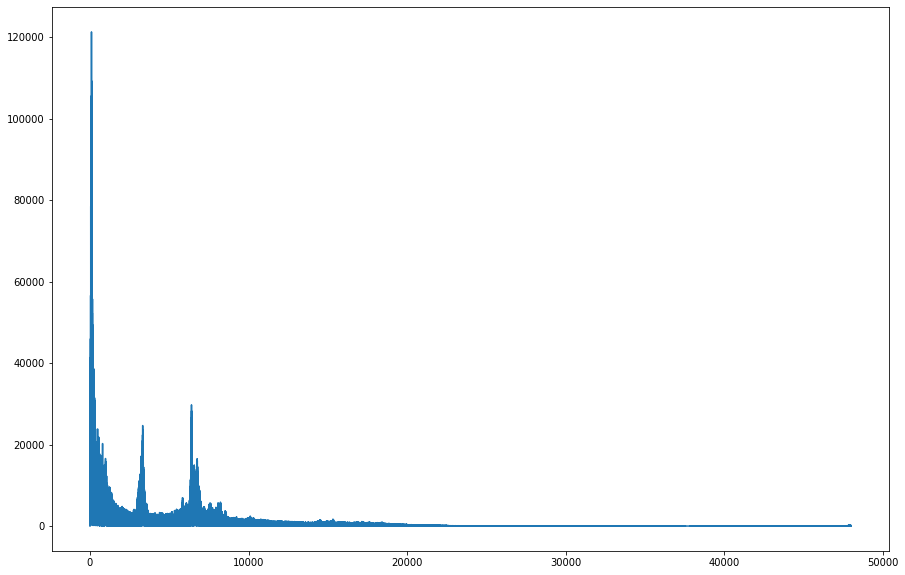

In [190]:
from scipy.fft import rfft, rfftfreq

def plot_rfft (sig: np.ndarray, sampling_freq: int, title: str = None):
    N = sig.shape[0]  # Number of samples

    yf = rfft(sig)
    xf = rfftfreq(N, 1 / sampling_freq)


    plt.figure(figsize=(15, 10))
    if title: plt.title(title)
    
    plt.plot(xf, np.abs(yf))
    plt.show()

plot_rfft (sig_std, sampling_freq)

<br>

### 1.4. Plot histogram

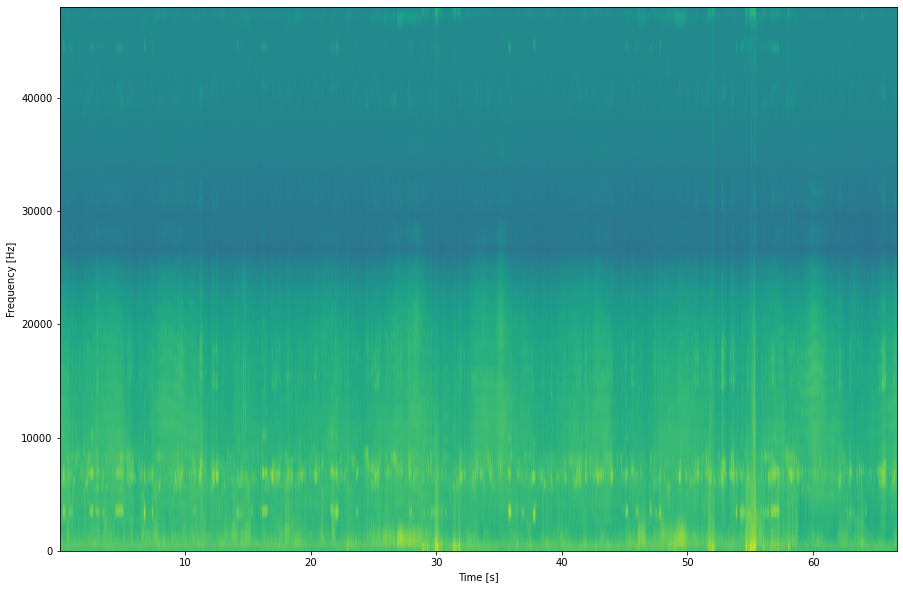

In [184]:
def plot_hist (sig: np.ndarray, sampling_freq: int, title: str = None):
    plt.figure(figsize=(15, 10))
    plt.specgram(sig, Fs=sampling_freq)

    if title: plt.title(title)

    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.show()

plot_hist(sig_std, sampling_freq)

<br>

### 1.5. Wavelet denoising

In [128]:
"""
Wavelets
|  LOW FREQS  |  HIGH FREQS |
|     a       |      d      |
"""


def reconstruct_wavelets (sig: np.ndarray, zones: list or tuple = ['a', 'd'], wavelet='db1') -> np.ndarray:
    wp = pywt.WaveletPacket(data=sig, wavelet='db1', mode='symmetric',  maxlevel=5)
    new_wp = pywt.WaveletPacket(data=None, wavelet='db1', mode='symmetric')

    # Fill new_wp
    for zone in zones:
        new_wp[zone] = wp[zone].data

    sig_new = new_wp.reconstruct()
    return sig_new


# zones = ('a',)
# sig_new = reconstruct_wavelets(sig_std, zones=zones)
# plot_sig(sig_new[:10000], sampling_freq)
# plot_hist(sig_new, sampling_freq)

In [129]:
# wavfile.write('out.wav', sampling_freq, sig_new)

<br>

### ?. Fourier Transform Denoising

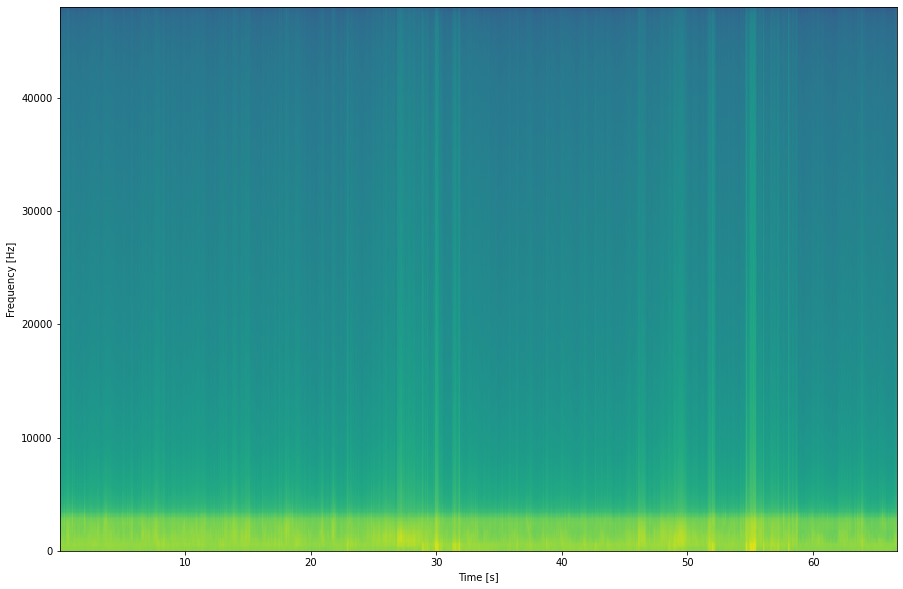

In [135]:
from scipy.fft import rfft, rfftfreq, irfft

yf = rfft(sig)
xf = rfftfreq(sig.shape[0], 1 / sampling_freq)

yf_filtered = yf.copy()
yf_filtered[xf > 2500] = 0

# plt.figure(figsize=(15, 10))
# plt.plot(xf, np.abs(yf_filtered))
# plt.show()


sig_filtered = irfft(yf_filtered)
plot_hist(sig_filtered, sampling_freq)

wavfile.write('out_filtered.wav', sampling_freq, sig_filtered)

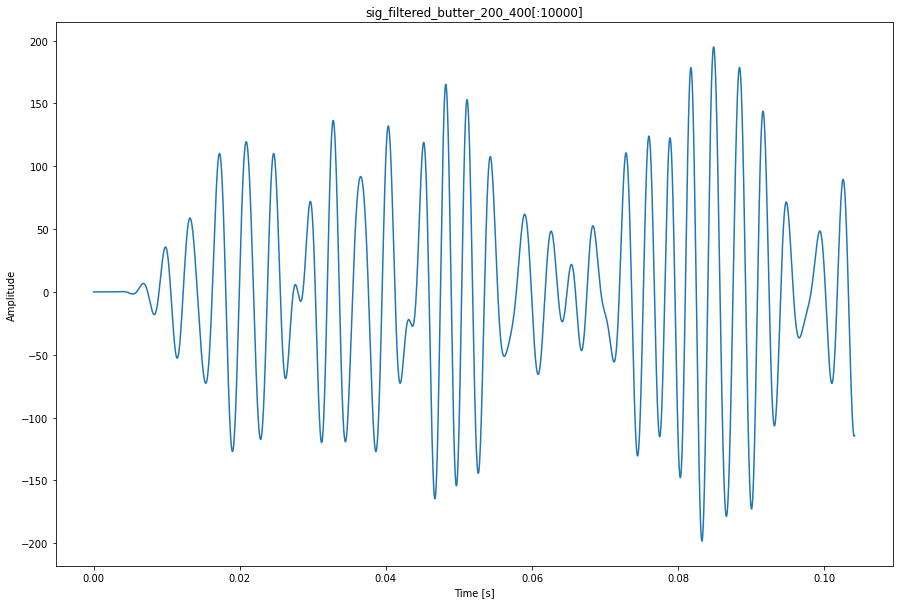

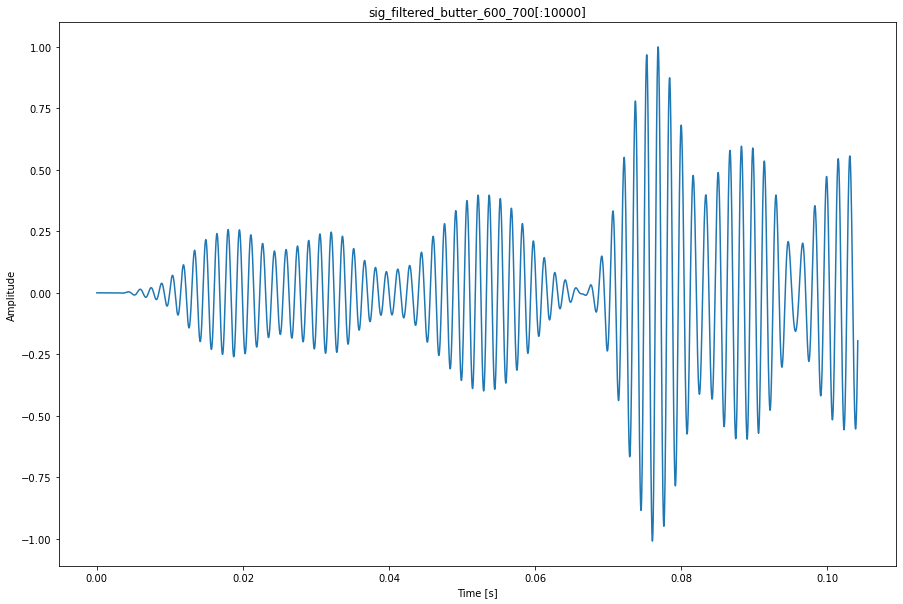

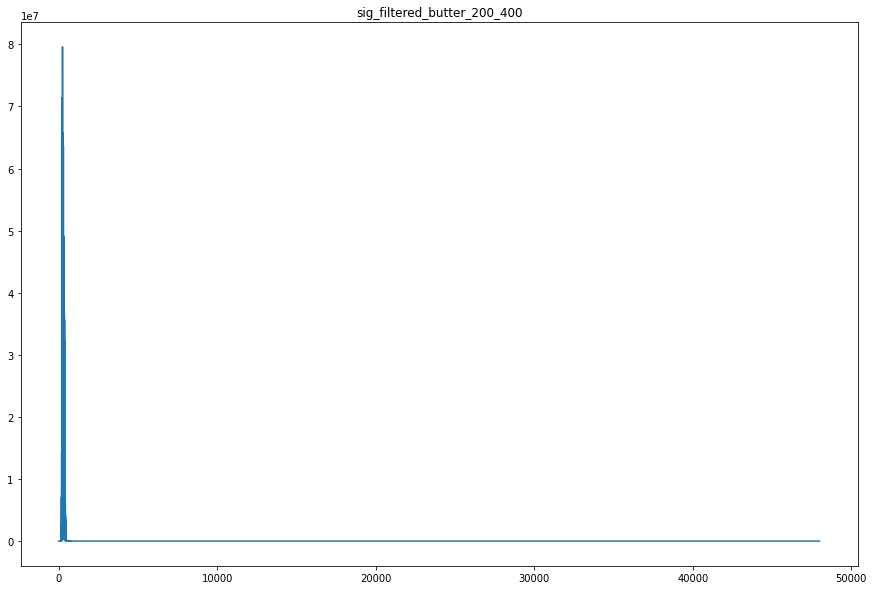

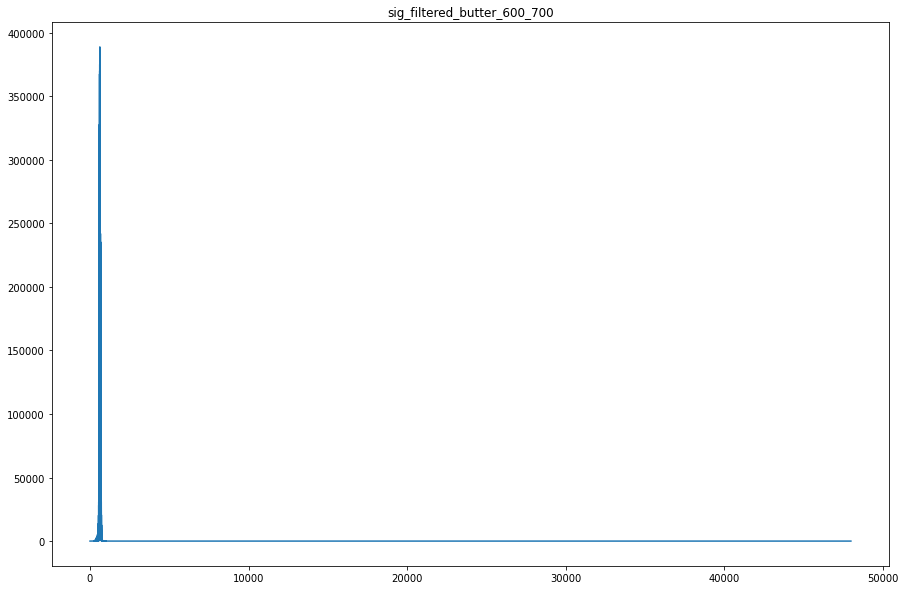

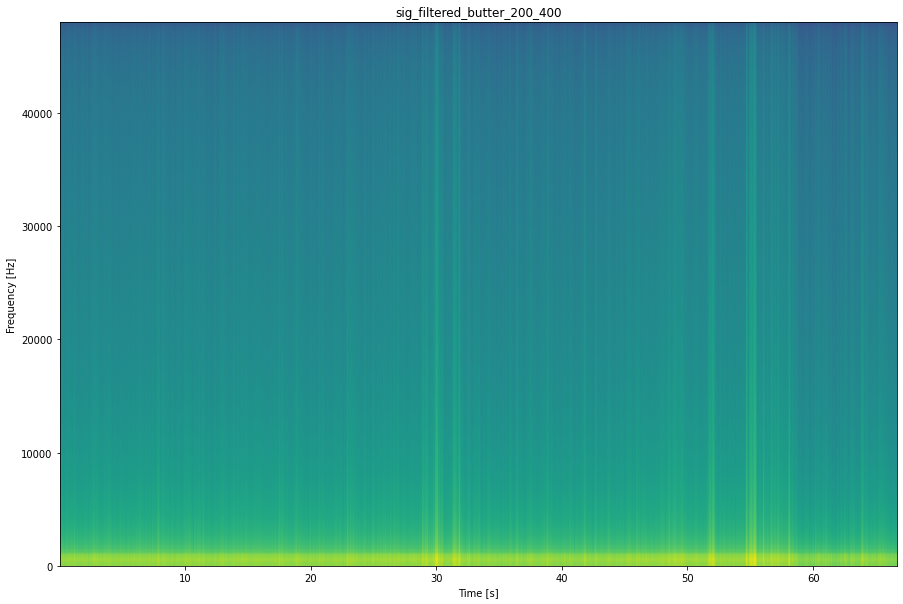

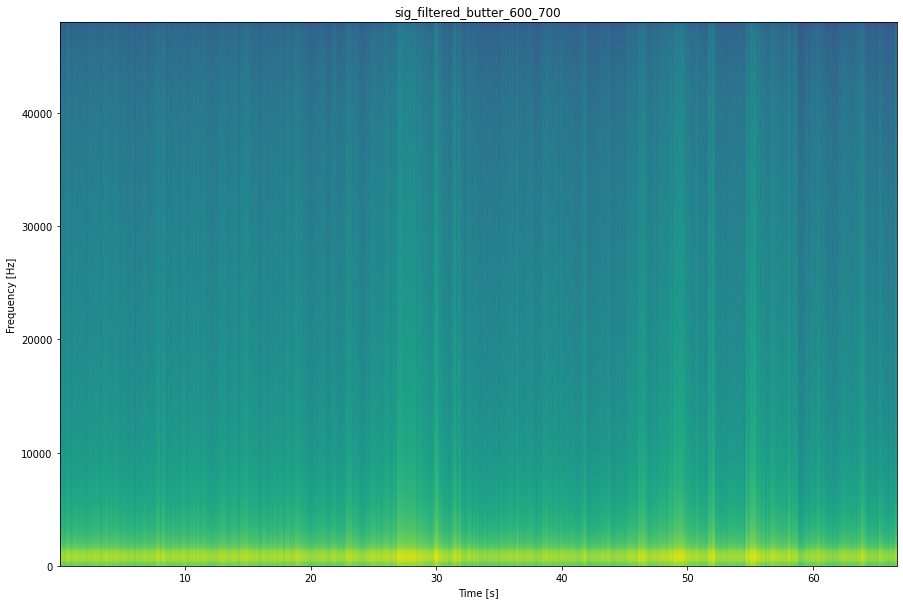

In [191]:
from scipy.signal import butter, sosfilt


sos_200_400 = butter(5, (200, 400), btype='band', fs=sampling_freq, output='sos')
sig_filtered_butter_200_400 = sosfilt(sos_200_400, sig)

sos_600_700 = butter(5, (600, 700), btype='band', fs=sampling_freq, output='sos')
sig_filtered_butter_600_700 = sosfilt(sos_600_700, sig)


plot_sig(sig_filtered_butter_200_400[:10000], sampling_freq, title='sig_filtered_butter_200_400[:10000]')
plot_sig(sig_filtered_butter_600_700[:10000], sampling_freq, title='sig_filtered_butter_600_700[:10000]')

plot_rfft(sig_filtered_butter_200_400, sampling_freq, title='sig_filtered_butter_200_400')
plot_rfft(sig_filtered_butter_600_700, sampling_freq, title='sig_filtered_butter_600_700')

plot_hist(sig_filtered_butter_200_400, sampling_freq, title='sig_filtered_butter_200_400')
plot_hist(sig_filtered_butter_600_700, sampling_freq, title='sig_filtered_butter_600_700')


wavfile.write('sig_filtered_butter_200_400.wav', sampling_freq, sig_filtered_butter_200_400)
wavfile.write('sig_filtered_butter_600_700.wav', sampling_freq, sig_filtered_butter_600_700)

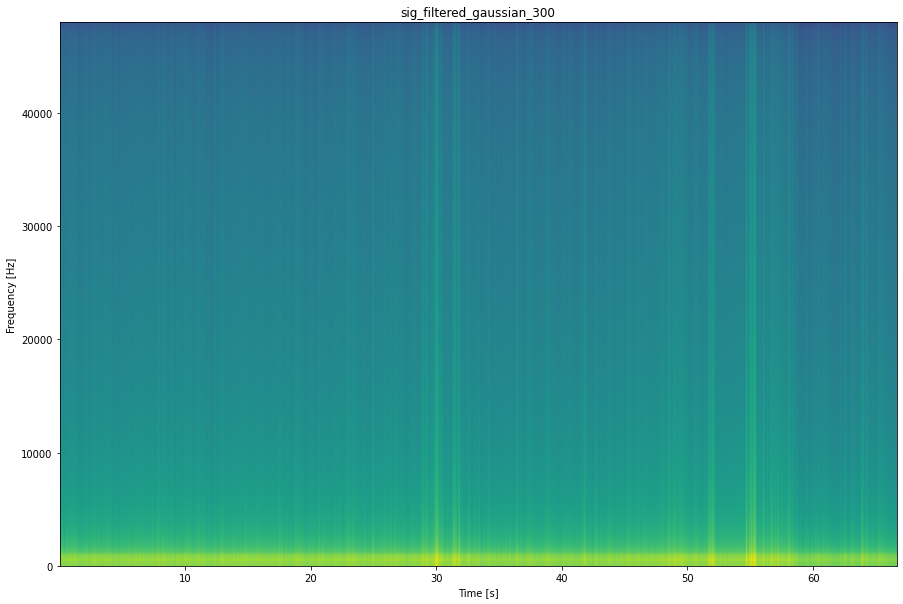

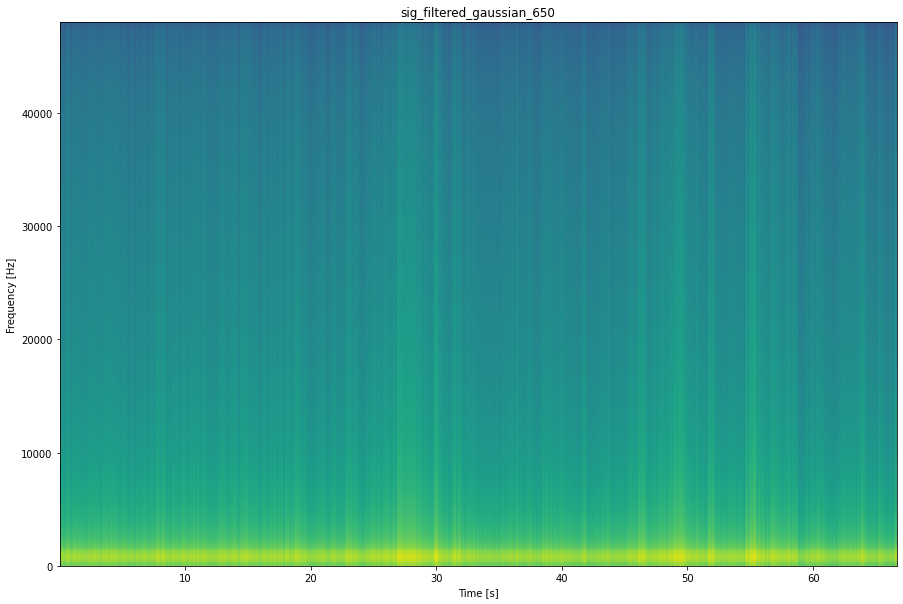

In [192]:
# from scipy.signal import windows
# w = windows.gaussian(200, std=7)
# plt.plot(np.arange(200), w)
# plt.show()

def gaussian_func (x, mean: float, stdev: float):
    v2p = np.sqrt(2 * np.pi)
    norm_mult = 1 / stdev / v2p
    exp_arg = -0.5 * ((x - mean) / stdev) ** 2
    return norm_mult * np.exp(exp_arg)


def apply_gaussian_filter (sig: np.ndarray, mean: float, stdev: float):
    yf = rfft(sig)
    xf = rfftfreq(sig.shape[0], 1 / sampling_freq)

    gaussian_filter = gaussian_func (xf, mean=mean, stdev=stdev)
    yf_filtered = np.multiply(yf, gaussian_filter)

    sig_filtered_gaussian = irfft(yf_filtered)
    return sig_filtered_gaussian
# plt.figure(figsize=(15, 10))
# plt.plot(xf, yf_filtered)
# plt.show()

sig_filtered_gaussian_300 = apply_gaussian_filter (sig, 300, 50)
sig_filtered_gaussian_650 = apply_gaussian_filter (sig, 650, 50)

plot_hist(sig_filtered_gaussian_300, sampling_freq, title='sig_filtered_gaussian_300')
plot_hist(sig_filtered_gaussian_650, sampling_freq, title='sig_filtered_gaussian_650')

wavfile.write('sig_filtered_gaussian_300.wav', sampling_freq, sig_filtered_gaussian_300)
wavfile.write('sig_filtered_gaussian_650.wav', sampling_freq, sig_filtered_gaussian_650)



<br>

### Short-term Fourier transform

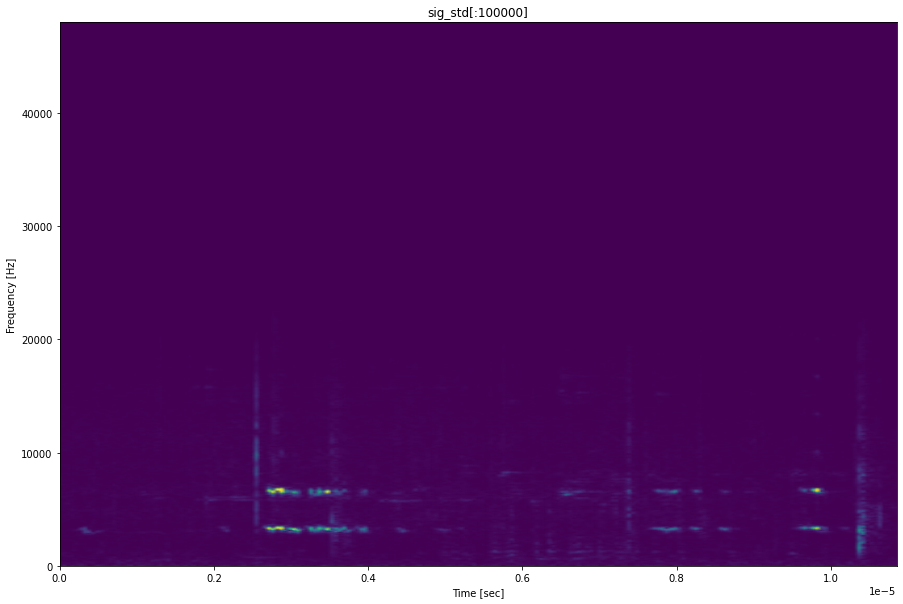

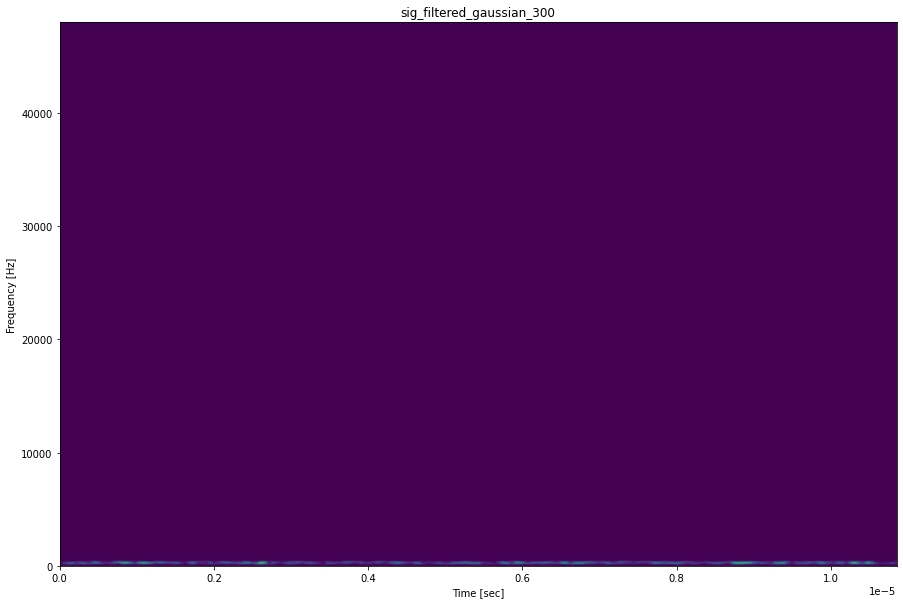

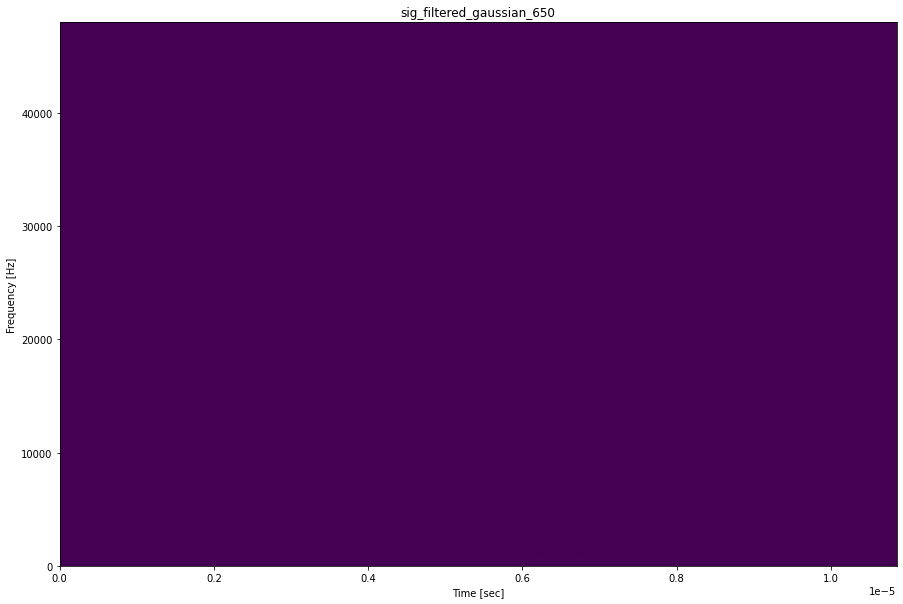

In [195]:
from scipy.signal import stft


def plot_stft (sig: np.ndarray, sampling_freq: int, title: str = None):
    plt.figure(figsize=(15, 10))

    f, t, Zxx = stft(sig, fs=sampling_freq, nperseg=1000)
    plt.pcolormesh(t/sampling_freq, f, np.abs(Zxx), vmin=0, vmax=1, shading='gouraud')

    if title: plt.title(title)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

plot_stft(sig_std[:100000], sampling_freq, title='sig_std[:100000]')
plot_stft(sig_filtered_gaussian_300[:100000], sampling_freq, title='sig_filtered_gaussian_300')
plot_stft(sig_filtered_gaussian_650[:100000], sampling_freq, title='sig_filtered_gaussian_650')

<br>

### Cross-correlation

In [149]:
from scipy.signal import correlate

corr = correlate(sig_std, sig_std, mode='full', method='auto')
# plt.figure(figsize=(15, 10))
# plt.plot(np.arange(corr.shape[0]), corr)
# plt.show()

<br>

### Spectral power density

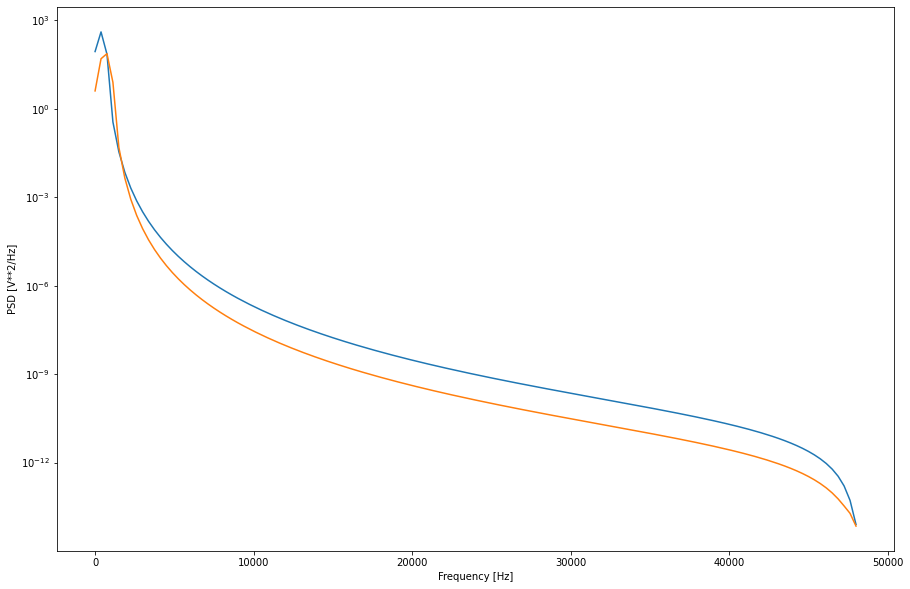

In [155]:
from scipy.signal import welch


def plot_psd (sig: np.ndarray, sampling_freq: int):
    f, Pxx_den = welch(sig, fs=sampling_freq)
    plt.semilogy(f, Pxx_den)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    

plt.figure(figsize=(15, 10))
plot_psd(sig_filtered_1, sampling_freq)
plot_psd(sig_filtered_2, sampling_freq)
plt.show()